# Ad Spend Optimization 

In [1]:
import pandas as pd
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import minimize

In [2]:
# Define the zip file path
zip_file_path = 'Social Media Advertising.zip'

# Step 1: Extract the dataset from zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()
    extracted_files = zip_ref.namelist()

csv_file_name = extracted_files[0]

# Load the CSV data into a pandas DataFrame
df = pd.read_csv(csv_file_name)

# Step 2: Initial Exploration of the Dataset
print("\n--- Initial Exploration of the Dataset ---")
print(df.head())  # Display the first few rows of the DataFrame
print(df.info())  # Print information about the DataFrame structure
print(df.describe(include='object'))  # Summary statistics for categorical features



--- Initial Exploration of the Dataset ---
   Campaign_ID Target_Audience     Campaign_Goal Duration Channel_Used  \
0       529013       Men 35-44    Product Launch  15 Days    Instagram   
1       275352     Women 45-60  Market Expansion  15 Days     Facebook   
2       692322       Men 45-60    Product Launch  15 Days    Instagram   
3       675757       Men 25-34    Increase Sales  15 Days    Pinterest   
4       535900       Men 45-60  Market Expansion  15 Days    Pinterest   

   Conversion_Rate Acquisition_Cost       ROI     Location Language  Clicks  \
0             0.15          $500.00  5.790000    Las Vegas  Spanish     500   
1             0.01          $500.00  7.210000  Los Angeles   French     500   
2             0.08          $500.00  0.430000       Austin  Spanish     500   
3             0.03          $500.00  0.909824        Miami  Spanish     293   
4             0.13          $500.00  1.422828       Austin   French     293   

   Impressions  Engagement_Score Cus

In [3]:
# Step 3: Clean Currency Columns
df['Acquisition_Cost'] = df['Acquisition_Cost'].replace('[\$,]', '', regex=True).astype(float)
print("\n--- Acquisition Cost Cleaned ---")
print(df['Acquisition_Cost'].head())  # Check the cleaned Acquisition Cost values

# Step 4: Handle Missing Values
print("\n--- Missing Values Analysis ---")
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

# Fill missing values
for col in missing_values.index:
    if df[col].dtype in ['float64', 'int64']:
        df[col].fillna(df[col].median(), inplace=True)
    else:
        df[col].fillna(df[col].mode()[0], inplace=True)

print("\n--- Missing Values After Filling ---")
print(df.isnull().sum())  # Verify that missing values have been handled


<>:2: SyntaxWarning: invalid escape sequence '\$'
<>:2: SyntaxWarning: invalid escape sequence '\$'
C:\Users\milto\AppData\Local\Temp\ipykernel_19544\2438053254.py:2: SyntaxWarning: invalid escape sequence '\$'
  df['Acquisition_Cost'] = df['Acquisition_Cost'].replace('[\$,]', '', regex=True).astype(float)



--- Acquisition Cost Cleaned ---
0    500.0
1    500.0
2    500.0
3    500.0
4    500.0
Name: Acquisition_Cost, dtype: float64

--- Missing Values Analysis ---
Missing Values:
 Campaign_ID         0
Target_Audience     0
Campaign_Goal       0
Duration            0
Channel_Used        0
Conversion_Rate     0
Acquisition_Cost    0
ROI                 0
Location            0
Language            0
Clicks              0
Impressions         0
Engagement_Score    0
Customer_Segment    0
Date                0
Company             0
dtype: int64


C:\Users\milto\AppData\Local\Temp\ipykernel_19544\2438053254.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\milto\AppData\Local\Temp\ipykernel_19544\2438053254.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa


--- Missing Values After Filling ---
Campaign_ID         0
Target_Audience     0
Campaign_Goal       0
Duration            0
Channel_Used        0
Conversion_Rate     0
Acquisition_Cost    0
ROI                 0
Location            0
Language            0
Clicks              0
Impressions         0
Engagement_Score    0
Customer_Segment    0
Date                0
Company             0
dtype: int64


In [4]:
# Step 5: Feature Engineering
print("\n--- Feature Engineering ---")
df['CPA'] = df['Acquisition_Cost'] / (df['Conversion_Rate'] * df['Clicks'])
df['CPA'].replace([np.inf, -np.inf], np.nan, inplace=True)
df['CPA'].fillna(0, inplace=True)
print("\n--- CPA Calculated ---")
print(df[['Acquisition_Cost', 'Clicks', 'Conversion_Rate', 'CPA']].head())  # Inspect CPA calculation

df['Total_Spend'] = df['Acquisition_Cost']  # Ensure this column is created
df['ROAS'] = (df['Clicks'] * df['Conversion_Rate'] * df['CPA']) / df['Total_Spend']
df['ROAS'].replace([np.inf, -np.inf], np.nan, inplace=True)
df['ROAS'].fillna(0, inplace=True)
print("\n--- ROAS Calculated ---")
print(df[['Clicks', 'Conversion_Rate', 'Total_Spend', 'ROAS']].head())  # Inspect ROAS calculation

df['CTR'] = df['Clicks'] / df['Impressions']
df['CTR'].replace([np.inf, -np.inf], np.nan, inplace=True)
df['CTR'].fillna(0, inplace=True)
print("\n--- CTR Calculated ---")
print(df[['Clicks', 'Impressions', 'CTR']].head())  # Inspect CTR calculation

df['Engagement_Rate'] = df['Engagement_Score'] / df['Impressions']
df['Engagement_Rate'].replace([np.inf, -np.inf], np.nan, inplace=True)
df['Engagement_Rate'].fillna(0, inplace=True)
print("\n--- Engagement Rate Calculated ---")
print(df[['Engagement_Score', 'Impressions', 'Engagement_Rate']].head())  # Inspect Engagement Rate calculation

# Extracting Date Features
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Week'] = df['Date'].dt.isocalendar().week
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Quarter'] = df['Date'].dt.quarter
df['Is_Weekend'] = df['Date'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)

print("\n--- Date Features Extracted ---")
print(df[['Date', 'Week', 'Month', 'Year', 'Quarter', 'Is_Weekend']].head())  # Inspect date features



--- Feature Engineering ---

--- CPA Calculated ---
   Acquisition_Cost  Clicks  Conversion_Rate         CPA
0             500.0     500             0.15    6.666667
1             500.0     500             0.01  100.000000
2             500.0     500             0.08   12.500000
3             500.0     293             0.03   56.882821
4             500.0     293             0.13   13.126805

--- ROAS Calculated ---
   Clicks  Conversion_Rate  Total_Spend  ROAS
0     500             0.15        500.0   1.0
1     500             0.01        500.0   1.0
2     500             0.08        500.0   1.0
3     293             0.03        500.0   1.0
4     293             0.13        500.0   1.0

--- CTR Calculated ---
   Clicks  Impressions       CTR
0     500         3000  0.166667
1     500         3000  0.166667
2     500         3000  0.166667
3     293         1937  0.151265
4     293         1937  0.151265

--- Engagement Rate Calculated ---
   Engagement_Score  Impressions  Engagement_R

C:\Users\milto\AppData\Local\Temp\ipykernel_19544\426280157.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['CPA'].replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\milto\AppData\Local\Temp\ipykernel_19544\426280157.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.



--- Date Features Extracted ---
        Date  Week  Month  Year  Quarter  Is_Weekend
0 2022-02-25     8      2  2022        1           0
1 2022-05-12    19      5  2022        2           0
2 2022-06-19    24      6  2022        2           1
3 2022-09-08    36      9  2022        3           0
4 2022-08-24    34      8  2022        3           0



--- Correlation Analysis ---


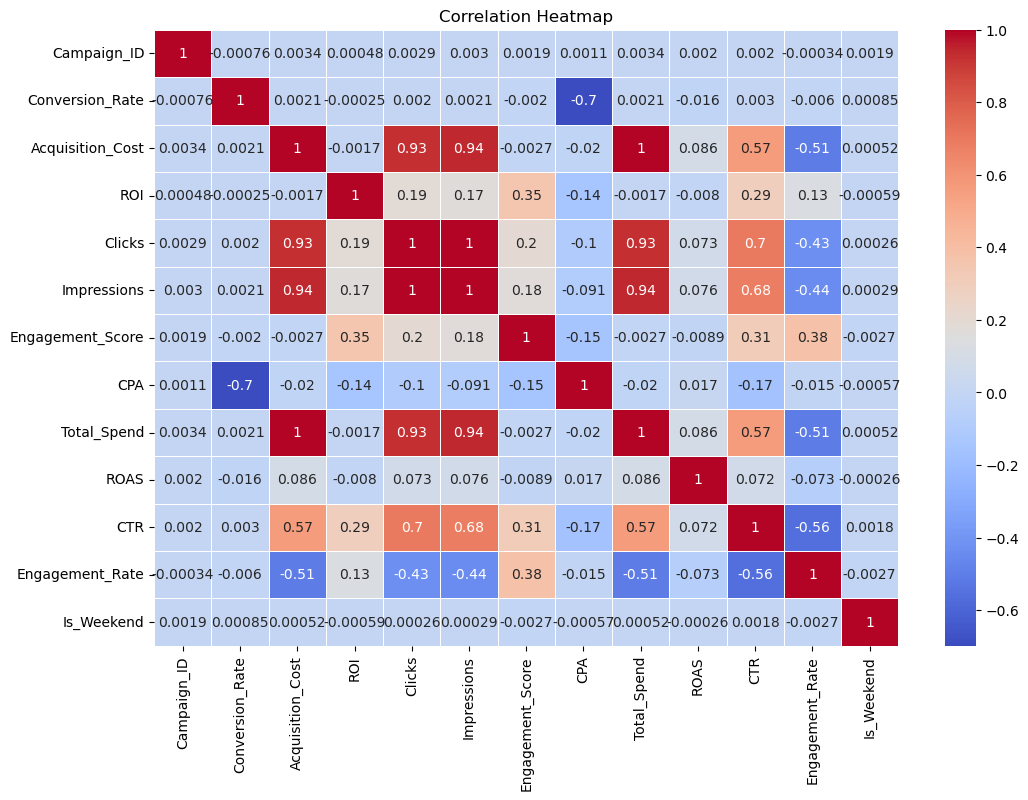

In [5]:
# Step 6: Correlation Analysis
print("\n--- Correlation Analysis ---")
numerical_df = df.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(12, 8))
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [6]:
# Step 7: Aggregating Data for Channel-wise Insights
weekly_channel_summary = df.groupby(['Year', 'Week', 'Channel_Used']).agg({
    'Total_Spend': 'sum',
    'Impressions': 'sum',
    'Clicks': 'sum',
    'Conversion_Rate': 'mean'
}).reset_index()

weekly_channel_summary['CPA'] = weekly_channel_summary['Total_Spend'] / weekly_channel_summary['Clicks']
weekly_channel_summary['ROI'] = (weekly_channel_summary['Clicks'] * weekly_channel_summary['Conversion_Rate'] * weekly_channel_summary['CPA']) / weekly_channel_summary['Total_Spend']
print("\n--- Weekly Channel Summary - First 5 Rows ---")
print(weekly_channel_summary.head())

# Step 8: Normalization and Encoding
# Scale numerical features
scaler = MinMaxScaler()
numerical_features = ['Acquisition_Cost', 'CPA', 'Total_Spend', 'CTR', 'Engagement_Rate', 'ROAS']
df[numerical_features] = scaler.fit_transform(df[numerical_features])
print("\n--- Normalized Numerical Features ---")
print(df[numerical_features].head())  # Inspect normalized features

# One-Hot Encoding of Categorical Features
df_encoded = pd.get_dummies(df, drop_first=True)
print("\n--- One-Hot Encoded Features ---")
print(df_encoded.head())  # Inspect the encoded DataFrame



--- Weekly Channel Summary - First 5 Rows ---
   Year  Week Channel_Used  Total_Spend  Impressions    Clicks  \
0  2022     1     Facebook  11804332.50     93653355  30848303   
1  2022     1    Instagram  11348167.63     90035429  29643276   
2  2022     1    Pinterest  11258441.01     57647423  17269543   
3  2022     1      Twitter  10654941.81     84482123  27823851   
4  2022     2     Facebook  10928516.64     86663693  28529074   

   Conversion_Rate       CPA       ROI  
0         0.080140  0.382657  0.080140  
1         0.078971  0.382824  0.078971  
2         0.078841  0.651925  0.078841  
3         0.080551  0.382943  0.080551  
4         0.079690  0.383066  0.079690  

--- Normalized Numerical Features ---
   Acquisition_Cost       CPA  Total_Spend       CTR  Engagement_Rate  \
0               0.0  0.034116          0.0  0.084986         0.699482   
1               0.0  0.662405          0.0  0.084986         0.498913   
2               0.0  0.073384          0.0  0.084986

In [7]:
# Step 9: Model Training
# Prepare features and target
X = df_encoded[['Total_Spend', 'Impressions', 'Clicks', 'Engagement_Score']]  # Features used for training
y = df_encoded['ROI']  # Target variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

# Store the trained models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Performance:")
    print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.2f}")
    print(f"R^2 Score: {r2_score(y_test, y_pred):.2f}")

# Use Random Forest for Budget Optimization
rf_model = models["Random Forest"]  # Get the trained Random Forest model
total_budget = 100000  # Example total budget
min_budget = 5000

# Define the objective function for optimization
def objective_function(budget_allocation):
    # Create a DataFrame with a budget scenario
    scenario_df = pd.DataFrame({
        'Clicks': [1000] * len(budget_allocation),  # Placeholder values
        'Conversion_Rate': [0.08] * len(budget_allocation),  # Placeholder values
        'Acquisition_Cost': budget_allocation,
        'Impressions': [10000] * len(budget_allocation),  # Placeholder values
        'Engagement_Score': [7] * len(budget_allocation)  # Placeholder values
    })
    
    # Calculate CPA and ROAS for the scenario_df
    scenario_df['CPA'] = scenario_df['Acquisition_Cost'] / (scenario_df['Conversion_Rate'] * scenario_df['Clicks'])
    scenario_df['CPA'].replace([np.inf, -np.inf], np.nan, inplace=True)
    scenario_df['CPA'].fillna(0, inplace=True)

    scenario_df['ROAS'] = (scenario_df['Clicks'] * scenario_df['Conversion_Rate'] * scenario_df['CPA']) / scenario_df['Acquisition_Cost']
    scenario_df['ROAS'].replace([np.inf, -np.inf], np.nan, inplace=True)
    scenario_df['ROAS'].fillna(0, inplace=True)

    # Prepare the DataFrame for prediction
    scenario_df['Total_Spend'] = scenario_df['Acquisition_Cost']  # Adding Total_Spend to the DataFrame
    prediction_features = ['Total_Spend', 'Impressions', 'Clicks', 'Engagement_Score']  # Ensure correct features are used
    scenario_df = scenario_df[prediction_features]

    print("\n--- Prediction Features for Scenario ---")
    print(scenario_df.head())  # Inspect the DataFrame used for prediction

    # Predict ROI using the trained model
    predicted_roi = rf_model.predict(scenario_df)
    return -np.sum(predicted_roi)  # Maximize ROI

# Constraints for optimization
constraints = (
    {'type': 'eq', 'fun': lambda x: np.sum(x) - total_budget},  # Total budget constraint
    {'type': 'ineq', 'fun': lambda x: x - min_budget}  # Minimum budget per channel
)

bounds = [(min_budget, total_budget) for _ in range(X.shape[1])]  # Ensure this matches the number of budget allocations

# Initial guess for budgets
initial_guess = [total_budget / X.shape[1]] * X.shape[1]

# Optimize budget allocation
result = minimize(objective_function, initial_guess, bounds=bounds, constraints=constraints, method='SLSQP')
if result.success:
    optimal_budgets = result.x
    print("\nOptimal Budget Allocation:")
    for i, budget in enumerate(optimal_budgets):
        print(f"Channel {i + 1}: ${budget:.2f}")
else:
    print("Optimization failed:", result.message)


Linear Regression Performance:
Mean Squared Error: 4.30
R^2 Score: 0.29

Random Forest Performance:
Mean Squared Error: 5.35
R^2 Score: 0.11

XGBoost Performance:
Mean Squared Error: 4.05
R^2 Score: 0.33

--- Prediction Features for Scenario ---
   Total_Spend  Impressions  Clicks  Engagement_Score
0      25000.0        10000    1000                 7
1      25000.0        10000    1000                 7
2      25000.0        10000    1000                 7
3      25000.0        10000    1000                 7

--- Prediction Features for Scenario ---
   Total_Spend  Impressions  Clicks  Engagement_Score
0      25000.0        10000    1000                 7
1      25000.0        10000    1000                 7
2      25000.0        10000    1000                 7
3      25000.0        10000    1000                 7

--- Prediction Features for Scenario ---
   Total_Spend  Impressions  Clicks  Engagement_Score
0      25000.0        10000    1000                 7
1      25000.0       

C:\Users\milto\AppData\Local\Temp\ipykernel_19544\3062739847.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  scenario_df['CPA'].replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\milto\AppData\Local\Temp\ipykernel_19544\3062739847.py:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behave